In [1]:
import torch
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

Испльзование заранее предобученной модели называется transfer learning. Оно бывает двух видов  

`finetuning` - во время дообучения обновляются все веса, которые есть в модели  

`feature extraction` - во время дообучения обновляются только веса последнего слоя. По сути  
   мы используем предобученную нейросеть, как готовый извлекатель признаков и лишь по новому  
   их комбинируем

для примера возьмем resnet18

Начнем с функции обучения 

In [2]:
import copy

def train(model, dataloaders, optim, lossFunc, epochs, device, inception = False):
    
    #эмулируем чекпоинты
    bestWeights = copy.deepcopy(model.state_dict())
    bestAcc = 0.0
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)
        for phase in ['train','val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            currentLoss = 0.0
            currentCorrects = 0

            for images, labels in dataloaders[phase]:
                images = images.to(device)
                labels = labels.to(device)
                
                optim.zero_grad()
                # то же самое, что и with torch.no_grad(), но включается по булу
                with torch.set_grad_enabled(phase == "train"):
                    if phase == 'train' and inception:
                        out, outAux = model(images)
                        loss1 = lossFunc(out, labels)
                        loss2 = lossFunc(outAux, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        out = model(images)
                        loss = lossFunc(out, labels)
                    _, preds = torch.max(out, 1)
                    if phase == "train":
                        loss.backward()
                        optim.step()
                
                currentLoss += loss.item() * images.size(0)
                currentCorrects += torch.sum(preds == labels.data)

            epochLoss = currentLoss / len(dataloaders[phase].dataset)
            epochAcc = currentCorrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epochLoss, epochAcc))

            if phase == 'val' and epochAcc > bestAcc:
                bestAcc = epochAcc
                bestWeights = copy.deepcopy(model.state_dict())
    print('Best val Acc: {:4f}'.format(bestAcc))
    model.load_state_dict(bestWeights)
    return model



Добавим функцию хелпер. В случае, если мы далем feature extraction, она проставит  
всем параметрам .requires_grad = False. Это нужно потому, что по дефолту претрейнд модели  
имеют для всех весов флаг True. Для файнтюнинга это норм, но если делаем feature extraction,  
то нам это не подходит.

In [3]:
def configParamsGrad(model, isFeatureExtracting):
    if isFeatureExtracting:
        for param in model.parameters():
            param.requires_grad = False

теперь самое интересное: настройка модели  
Как и говорилось ранее, голову мы отрываем в любом случае. Важно лишь то, что это не   
бойлерплейт код, каждая модель уникальна и написана по своему. Поэтому важно отрывать  
только последний слой, т.е. классификатор, в который фичемапы попадают после флаттен слоя  

Кстати в случае с Inception появляются дополнительные манипуляции. Как известно  
Для борьбы с затуханием градиентов он использует вспомогательный классификатор, так что  
отрезать головы надо обоим классификатором

In [4]:
from torchvision import models

def initModel(modelName, featureExtracting, amountOfClasses):
    model = None 
    inputSize = 0 
    if modelName =="resnet":
        model = models.resnet18(pretrained=True)
        configParamsGrad(model, featureExtracting)
        inFeatures = model.fc.in_features
        model.fc = torch.nn.Linear(inFeatures, amountOfClasses)
        inputSize = 224
    elif modelName == "inception":
        model = models.inception_v3(pretrained=True)
        configParamsGrad(model, featureExtracting)
        inAux = model.AuxLogits.fc.in_features
        model.AuxLogits.fc = torch.nn.Linear(inAux, amountOfClasses)
        inMain = model.fc.in_features
        model.fc = torch.nn.Linear(inMain, amountOfClasses)
        inputSize = 299

    return model, inputSize
    

Загружаем данные

In [7]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
import os 
from torch.utils.data import DataLoader

rootDir = "./data/hymenoptera_data/"
extracting = True
amountOfClasses = 2 
model, inputSize = initModel("inception", extracting, amountOfClasses)
batchSize = 8 

dataTransforms = {
    'train': T.Compose([
        T.RandomResizedCrop(inputSize),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': T.Compose([
        T.Resize(inputSize),
        T.CenterCrop(inputSize),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
datasets = {x: ImageFolder(os.path.join(rootDir, x), dataTransforms[x]) for x in ["train", "val"]}
dataloaders = {x: DataLoader(datasets[x], batch_size=batchSize, shuffle=True) for x in ["train", "val"] }

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Теперь оптимайзер. Если мы делаем фичер экстрактинг, то нам нужно  
передать только те параметры, которые мы только что проинициализировали  
Если делаем файнтюн, то учим все слои 

In [8]:
from torch.optim import SGD

model.to(device)
paramsToOptim = model.parameters()
if extracting:
    paramsToOptim = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            paramsToOptim.append(param)
            print(name)
else:
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name)

optimizer = SGD(paramsToOptim, lr=0.001, momentum=0.9)

AuxLogits.fc.weight
AuxLogits.fc.bias
fc.weight
fc.bias


In [10]:
lossFunc = torch.nn.CrossEntropyLoss()
amountOfEpochs = 15
model = train(model, dataloaders,optimizer, lossFunc, amountOfEpochs,device, inception=True)

Epoch 0/14
----------
train Loss: 0.8643 Acc: 0.6270
val Loss: 0.4746 Acc: 0.8824
Epoch 1/14
----------
train Loss: 0.6142 Acc: 0.8115
val Loss: 0.3876 Acc: 0.8301
Epoch 2/14
----------
train Loss: 0.5532 Acc: 0.8320
val Loss: 0.3513 Acc: 0.8431
Epoch 3/14
----------
train Loss: 0.4569 Acc: 0.8689
val Loss: 0.2928 Acc: 0.9020
Epoch 4/14
----------
train Loss: 0.4243 Acc: 0.8689
val Loss: 0.2475 Acc: 0.9346
Epoch 5/14
----------
train Loss: 0.4245 Acc: 0.8770
val Loss: 0.2274 Acc: 0.9477
Epoch 6/14
----------
train Loss: 0.4035 Acc: 0.8730
val Loss: 0.2718 Acc: 0.8889
Epoch 7/14
----------
train Loss: 0.4361 Acc: 0.8730
val Loss: 0.3189 Acc: 0.8693
Epoch 8/14
----------
train Loss: 0.5278 Acc: 0.8074
val Loss: 0.2113 Acc: 0.9346
Epoch 9/14
----------
train Loss: 0.4049 Acc: 0.8648
val Loss: 0.2096 Acc: 0.9281
Epoch 10/14
----------
train Loss: 0.3611 Acc: 0.8770
val Loss: 0.2175 Acc: 0.9346
Epoch 11/14
----------
train Loss: 0.3832 Acc: 0.8811
val Loss: 0.1977 Acc: 0.9216
Epoch 12/14
--

ну, ради интереса можно заинференсить

prdicted class: bees


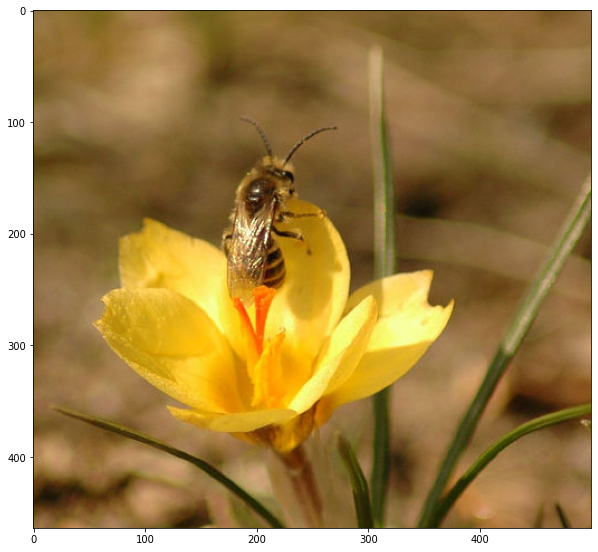

In [11]:
from PIL import Image
img = Image.open("./data/hymenoptera_data/val/bees/10870992_eebeeb3a12.jpg")
transforms = T.Compose([T.Resize(inputSize),T.ToTensor()])
f = plt.figure(figsize=(10,10))
plt.imshow(img)
img = transforms(img).unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    pred = model(img).to("cpu")

print("prdicted class:", datasets["val"].classes[pred.argmax()])